# Lecture 7) Bagging, Random Forests & Boosting

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn as sl

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from sklearn import linear_model

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import BaggingClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor


%matplotlib inline
import scipy as sc
import math as ma
from scipy import linalg, optimize, constants, interpolate, special, stats
from math import exp, pow, sqrt, log

import seaborn as sns #spezielle Graphikdarstellungen
import statsmodels.api as sm
import statsmodels.stats.api as sms



Decision Trees haben viele Vorteile, aber liefern unter Umständen nicht die allerbesten Prognosen.

Dagegen kann man was tun :-)

### 7.1) Bagging

Wir starten mit einer Variante des Bagging für einen Regression Tree.
Dafür haben wir beim letzten Mal den Auto-Datensatz verwendet...

In [2]:
Auto = pd.read_csv("../Daten/Auto.csv")
Auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [3]:
X=np.array(Auto[['cylinders','displacement','horsepower','weight','acceleration','year']])
y=np.array(Auto['mpg'])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle='True')

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Sklearn hat eine Funktion um für alle implementierten Regressionsmodelle Bagging anzuwenden.
Es ist der BaggingRegressor aus den verfügbaren Ensemble-Verfahren.

Es werden dabei aus der verfügbaren Trainingsmenge mit Hilfe von Bootstrapping $B$ verschiedene Trainingsmengen erzeugt.
Die Anzahl der Trainingsmengen $B$ ist dabei ein Meta-Parameter (Option: n_estimators=B).

Die finale Prognose wird dann als Mittelwert der $B$ Prädiktoren ermittelt:

$\hat{f}_{bag}(x)=\frac{1}{B}\sum_{b=1}^B \hat{f}^{*b}(x)$

Möchte man beim Bootstrapping mit Zurücklegen ziehen, muß man die Option bootstrap=True mitnehmen (default). Sonst wird ohne Zurücklegen gezogen und die Anzahl der Modelle ist damit automatisch beschränkt.

In [5]:
from sklearn.ensemble import BaggingRegressor

AutoBagReg = BaggingRegressor(base_estimator=DecisionTreeRegressor(),
                         n_estimators=10, random_state=0, bootstrap=True).fit(X_train, y_train)

In [6]:
y_hat_train_Bag = AutoBagReg.predict(X_train)
y_hat_test_Bag = AutoBagReg.predict(X_test)
y_hat_test_Bag;

In [7]:
rmseTree_Bag_tr = sqrt(mean_squared_error(y_hat_train_Bag,y_train)) 
rmseTree_Bag_test = sqrt(mean_squared_error(y_hat_test_Bag,y_test)) 

print('Trainingsfehler:',rmseTree_Bag_tr)
print('Testfehler:',rmseTree_Bag_test)

Trainingsfehler: 1.0381923334814407
Testfehler: 3.217419773669578


Als score der automatisch ausgegeben wird, hat sklearn den r2-score implementiert:

In [8]:
AutoBagReg_test_r2=AutoBagReg.score(X_test,y_test)

AutoBagReg_test_r2

0.8342280151227657

### Aufgabe 1)

- Finden Sie heraus, für welche Anzahl von Modellen (n_estimators) man mit dem Verfahren den besten Testfehler erzielt.

Möchte man bewußt auf eine Testmenge verzichten, z.B. weil sehr wenig Daten zur Verfügung stehen, dann kann man den Testfehler mit Hilfe der Out-Of-Bag Fehlerschätzung berechnen.

Dazu läßt man sich als score den OOB-Score (oob_score=True) ausgeben.
Zu beachten ist, daß die Anzahl der Modelle nicht zu klein sein darf, weil sonst die OOB-Schätzung nicht mehr aussagekräftig ist.

In [9]:
scalerOOB = MinMaxScaler()
X_train_OOB = scaler.fit_transform(X_train)
X_test_OOB = scaler.transform(X_test)
y_train_OOB=y_train
y_test_OOB=y_test
#X_test = scaler.transform(X_test)

In [10]:
AutoBagReg_OOB = BaggingRegressor(base_estimator=DecisionTreeRegressor(),
                         n_estimators=10, random_state=0, bootstrap=True, 
                                  oob_score=True)

AutoBagReg_OOB.fit(X_train_OOB, y_train_OOB)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py:1069: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


BaggingRegressor(base_estimator=DecisionTreeRegressor(), oob_score=True,
                 random_state=0)

Als score wird für die OOB-samples der r2-score ausgegeben. Also das Quadrat der Pearson-Korrelation zwischen Output und Target.

In [11]:
#r2-score (OOB)
AutoBagReg_OOB_r2=AutoBagReg_OOB.oob_score_

#Pearson-Korrelation (OOB)
corr_OOB=sqrt(AutoBagReg_OOB_r2)


Jetzt kann man prüfen, wie nahe man damit dem Fehler auf der Testmenge kommt:

In [12]:
y_hat_OOB=AutoBagReg_OOB.predict(X_test_OOB)
#accuracy_score(y_test_OOB,y_hat_OOB)

corr_test_OOB=np.corrcoef(y_hat_OOB,y_test_OOB)[0,1]

In [13]:
print('Korrelation auf den OOB samples:',corr_OOB)
print('Korrelation auf der Testmenge:',corr_test_OOB)


Korrelation auf den OOB samples: 0.8945337389270079
Korrelation auf der Testmenge: 0.9153585701763227


Das legt nahe, daß wir tatsächlich auf eine Testmenge verzichten könnten und als Schätzung des Fehlers den OOB-Fehler verwenden könnten.
Vorteil: mehr Daten zum Training!

### Aufgabe 2)

- wie groß muß die Anzahl der Modelle mindestens sein, damit die Schätzung stabil ist (sh. warning)?
- Verwenden Sie jetzt alle Daten aus Train+Test für den OOB-Schätzer. Wie verändert sich der (geschätzte) Fehler?


Bagging funktioniert natürlich nicht nur für Regressionsmodelle sondern auch für Klassifikation.
Dazu braucht man allerdings den BaggingClassifier...

In [14]:
from sklearn.ensemble import BaggingClassifier

Beim letzten Mal hatten wir einen Standard-Classifier (Decision Tree) für den heart-Datensatz aufgesetzt

In [15]:
Heart = pd.read_csv("../Daten/heart.csv")
#len(Heart)
#Heart.head()

Heart_y=Heart['AHD']
Heart_X=np.array(Heart[['Age','Sex','RestBP','Chol','Fbs','RestECG','MaxHR','ExAng','Oldpeak','Slope']])


Heart_y=np.array(Heart_y.replace(['No', 'Yes'], [0,1]))
#Heart_y

X_train_H, X_test_H, y_train_H, y_test_H = train_test_split(Heart_X, Heart_y, test_size=0.3, shuffle='True')

In [16]:
from sklearn.tree import DecisionTreeClassifier

# Modell spezifizieren (max. Tiefe = 3)
# Entscheidungskriterium ist im default 'gini' (sonst 'entropy' wählen)

heart_tree=DecisionTreeClassifier(max_depth=3,criterion='gini') 

# Modell an die Trainingsdaten anpassen
heart_tree.fit(X_train_H,y_train_H)

DecisionTreeClassifier(max_depth=3)

In [17]:
heart_tr_score=heart_tree.score(X_train_H, y_train_H, sample_weight=None)
heart_test_score=heart_tree.score(X_test_H, y_test_H, sample_weight=None)

print('Trainings-Score:',heart_tr_score,'; Test-Score:',heart_test_score)

Trainings-Score: 0.7904761904761904 ; Test-Score: 0.7


### Aufgabe 3)

- Wenden Sie den sklearn BaggingClassifier für den Fall der Klassifikation von Herzinfarkten an.
- Verbessert sich das Ergebnis?

### 7.2) Random Forests

Eine weitere Möglichkeit die Performance von einfachen Decision Trees zu verbessern ist der Random Forest.
Bei der Teilung an den Knoten wird dabei nur eine Auswahl von Input-Features verwendet.
Das führt zu einer Dekorrelation der einzelnen Bäume, was sich positiv auf den Fehler des Ensemble-Schätzers auswirkt.

Random Forests können sowohl für die Regression als auch für die Klassifikation verwendet werden.
Man benötigt dann entweder den RandomForestClassifier oder den RandomForestRegressor...


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

hier erstmal das Beispiel für die Klassifikation (heart-Datensatz):

In [19]:
RF_Heart=RandomForestClassifier(n_estimators=100, max_leaf_nodes=10)
RF_Heart=RF_Heart.fit(X_train_H,y_train_H)

In [20]:
RF_Heart.score(X_test_H, y_test_H)

0.7666666666666667

In [21]:
y_hat_RF_Heart=RF_Heart.predict(X_test_H)

In [22]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test_H, y_hat_RF_Heart))

Accuracy: 0.7666666666666667


In [23]:
print("Confusion Matrix:")
print(confusion_matrix(y_test_H, y_hat_RF_Heart))

Confusion Matrix:
[[39  1]
 [20 30]]


Die Feature Importance läßt sich auch ganz leicht ausgeben. Die Werte beziehen sich auf die Reihenfolge der Input-Features in der Datenmatrix X

In [24]:
ImpArray=np.transpose([['Age','Sex','RestBP','Chol','Fbs','RestECG','MaxHR','ExAng','Oldpeak','Slope'],RF_Heart.feature_importances_])

In [25]:
ImpArray

array([['Age', '0.07007351066400488'],
       ['Sex', '0.09695236738980925'],
       ['RestBP', '0.08328258138377168'],
       ['Chol', '0.0956934681864803'],
       ['Fbs', '0.007638600974076198'],
       ['RestECG', '0.021879798179898508'],
       ['MaxHR', '0.21885351305570627'],
       ['ExAng', '0.11116409382595856'],
       ['Oldpeak', '0.2357226545741275'],
       ['Slope', '0.058739411766166746']], dtype='<U32')

In [26]:
n_estimators_list=[]
train_score_list=[]
test_score_list=[]

for k in range(1, 200):
    RF_Heart=RandomForestClassifier(n_estimators=k, max_leaf_nodes=2)
    RF_Heart=RF_Heart.fit(X_train_H,y_train_H)
    
    train_score=RF_Heart.score(X_train_H, y_train_H)
    test_score=RF_Heart.score(X_test_H, y_test_H)
    
    train_score_list.append(train_score)
    test_score_list.append(test_score)
    n_estimators_list.append(k)

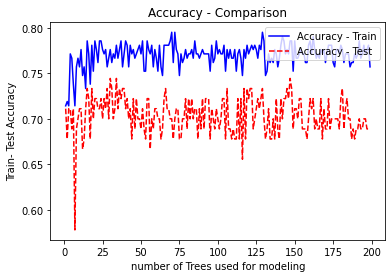

In [27]:
plt.plot(n_estimators_list,train_score_list,'b-',label='Accuracy - Train');
plt.plot(n_estimators_list,test_score_list,'r--',label='Accuracy - Test');

plt.xlabel('number of Trees used for modeling')
plt.ylabel('Train- Test Accuracy') 
plt.title('Accuracy - Comparison')

#Befehl zum Anzeigen der Graphik mit Angabe der Position
plt.legend(loc='upper right');

### Aufgabe 4)

- Hat die maximale Anzahl der leaf Nodes einen Einfluß?

Für Regressionsprobleme funktioniert das Ganze analog.

- Testen Sie das Ergebnis eines Random Forest für unser Regressionsproblem (Auto-Daten) mit Hilfe des RandomForestRegressor.

### 7.3) Boosting

Beim Boosting versucht man mehrere ML-Verfahren (können gleich oder auch verschieden sein) so zu kombinieren, daß die Prädiktoren versuchen die Fehler ihrer Vorgänger zu korrigieren (Residual Learning).

Das kann ganz unterschiedlich aussehen und ist sowohl für Regression als auch für Klassifikation einsetzbar:

#### AdaBoost = Adaptive Boosting

Der Prädiktor korrigiert seine Vorgänger, indem die vorher falsch klassifizierten Samples stärker gewichtet werden.  Man geht dann davon aus, daß diese Samples dann Stück für Stück besser getroffen werden.

#### Gradient Boosting

Der Prädiktor lernt den Restfehler seiner Vorgänger (sh. Vorlesung). Alle Prädiktoren werden dann am Ende zu einem Modell zusammengesetzt.



### 7.3.1) AdaBoost

Hier ein Beispiel für unser Klassifikationsproblem und DecisionTree Classifiers: 
Metaparameter: 
- maximale Tiefe der Bäume
- Anzahl der Schätzer
- Lernrate
kontrolliert wieviel das neue Modell zum bestehenden beitragen darf, bzw. wie schlecht klassifizierte Beispiele gewichtet werden.  
Generell gilt: kleines $\eta \Rightarrow$ mehr Iterationen

Im Default ist für die maximale Tiefe 1 eingestellt. Die einzelnen Modelle haben also jeweils nur einen inneren Knoten (stumps).

In [28]:
from sklearn.ensemble import AdaBoostClassifier
#from sklearn.ensemble import AdaBoostRegressor

In [29]:
ada_Heart=AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=100,learning_rate=0.5)

ada_Heart.fit(X_train_H,y_train_H)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=100)

In [30]:
ada_Heart.score(X_test_H, y_test_H)

0.7333333333333333

In [31]:
y_hat_test_ada=ada_Heart.predict(X_test_H)

In [32]:
print("Confusion Matrix:")
print(confusion_matrix(y_test_H, y_hat_test_ada))

Confusion Matrix:
[[35  5]
 [19 31]]


Das Verfahren ist stark von der Lernrate beeinflußt.
Das kann man sehen, wenn man bei gleichbleibender Zahl der Modelle die Lernrate von z.B. 0.01 bis 1 variiert:

In [33]:
lr_list=[]
train_score_list_ada=[]
test_score_list_ada=[]

for k in range(1, 100):
    lr=k/100
    ada_Heart=AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=100,learning_rate=lr)
    ada_Heart.fit(X_train_H,y_train_H)
    
    train_score=ada_Heart.score(X_train_H, y_train_H)
    test_score=ada_Heart.score(X_test_H, y_test_H)
    
    train_score_list_ada.append(train_score)
    test_score_list_ada.append(test_score)
    lr_list.append(lr)

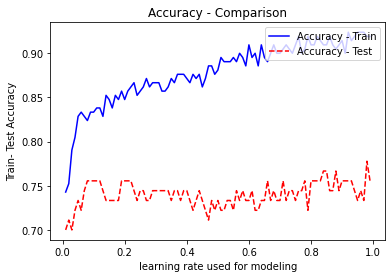

In [34]:
plt.plot(lr_list,train_score_list_ada,'b-',label='Accuracy - Train');
plt.plot(lr_list,test_score_list_ada,'r--',label='Accuracy - Test');

plt.xlabel('learning rate used for modeling')
plt.ylabel('Train- Test Accuracy') 
plt.title('Accuracy - Comparison')

#Befehl zum Anzeigen der Graphik mit Angabe der Position
plt.legend(loc='upper right');

### Aufgabe 6)

Natürlich hängen optimale Zahl von Modellen und optimale Lernrate miteinander zusammen.

- bestimmen Sie die optimale Lernrate (Minimum des Testfehlers sh. oben) für eine veränderliche Anzahl von Modellen in einer entsprechenden Schleife.
- Tragen Sie die Anzahl der Modelle (x-Achse) gegen das Optimum der Lernrate (y-Achse) in eine Graphik ein.
- Was läßt sich daraus erkennen? Gibt es eine Systematik?

### 7.3.2) Gradient Boosting

Der in sklearn implementierte GradientBoostingClassifier benutzt als Modellklasse DecisionTrees.
Fast alle Methoden für Decision Trees können als Optionen mitgegeben werden.

Im Beispiel ist das:

- maximale Tiefe des Baumes (kann aber z.B. durch min. Anzahl samples etc. ersetzt wereden)
- Anzahl der Modelle
- Lernrate (shrinkage Parameter $\lambda$, sh. Vorlesung)

Allgemein gilt: kleine $\lambda$ führen dazu, daß man i.A. mehr Bäume braucht. dafür generalisieren die Modelle besser.  
Allerdings: Boosting-Modelle mit zu vielen Bäumen führen zu overfitting. Das kann man z.B. beheben, indem man Trainings- und Testfehler tracked und das Optimum im Testfehler auswählt (Early Stopping). 


In [35]:
from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.ensemble import GradientBoostingRegressor

In [36]:
GBC_Heart=GradientBoostingClassifier(max_depth=3,n_estimators=100,learning_rate=0.1)

GBC_Heart.fit(X_train_H,y_train_H)

GradientBoostingClassifier()

In [37]:
GBC_Heart.score(X_test_H, y_test_H)

0.7444444444444445

### Aufgabe 7)

- Versuchen Sie ein early Stopping für den Gradient Boosting Algorithmus zu implementieren.
- Lassen Sie sich die Trainings- und Testfehler vs. n_estimators für verschiedene Lernraten in einer Graphik ausgeben. Welchen Einfluß hat der shrinkage Parameter $\lambda$?

#### Bemerkung:

Gradient Boosting ist auch in der Python Bib XGBoost umgesetzt.
Hier gibt es eine Menge netter Zusatzfeatures (z.B. implementiertes Early Stopping).